# Causal Inference

## *Workshop 10*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W10.%20Causal%20Inference.ipynb)

### Aims:

This workshop builds on last week's material-- now that we know what a basic regression looks like, we'll be looking at three different types of regression that let us extract more robust and even plausibly causal insights from our data:

1. Panel Regression 
2. Difference in Differences 
3. Regression Discontinuity

Our focus area will be the United States, where we'll be looking at the relationship between electoral outcomes, unemployment, and the minimum wage. We'll also be bringing back material from previous weeks (particularly Week 3 - Spatial Data and Week 5 - Merging and Joining) to show how the different things we've learned fit together. First, as always, we must import the libraries we'll need for this project.

In [1]:
#!pip install linearmodels
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

This workshop is going to involve combining a number of different datasets:

* `state_data.csv`: Monthly state-level unemployment data from the [Bureau of Labor Statistics (BLS)](www.bls.gov) spanning 1976-2022, and state-level minimum wage data from [Kaggle](https://www.kaggle.com/datasets/lislejoem/us-minimum-wage-by-state-from-1968-to-2017) spanning 1968-2020.

* `elections.csv`: county-level U.S. Presidential election results spanning 2000-2020 from the [MIT Election Lab](https://electionlab.mit.edu/data).

* `geojson-counties-fips.json`: a county-level geospatial file used for making maps. 

In [31]:
!mkdir data
!mkdir data/wk10
!curl https://storage.googleapis.com/qm2/wk10/state_data.csv -o data/wk10/state_data.csv
!curl https://storage.googleapis.com/qm2/wk10/elections.csv -o data/wk10/elections.csv
!curl https://storage.googleapis.com/qm2/wk10/geojson-counties-fips.json -o data/wk10/geojson-counties-fips.json

mkdir: data: File exists
mkdir: data/wk10: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2424k  100 2424k    0     0  6772k      0 --:--:-- --:--:-- --:--:-- 6848k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  875k  100  875k    0     0  1538k      0 --:--:-- --:--:-- --:--:-- 1548k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3141k  100 3141k    0     0  8346k      0 --:--:-- --:--:-- --:--:-- 8399k


In [17]:
counties=pd.DataFrame() # create empty dataframe to store the county data for each year

for year in range (2008,2022): # loop through years from 1990 to 2021
    annual=pd.read_csv('https://www.bls.gov/lau/laucnty'+str(year)[-2:]+'.txt', sep="\s{2,}", header=3, on_bad_lines='skip', engine='python', skipfooter=2) # read in the data for each year by adding the last two digits of the year to the url
    annual=annual[['Code','Code.1','Year','Rate','Force']].rename(columns={'Code':'state','Code.1':'county','Year':'year','Rate':'unemployment','Force':'population'}) # rename the columns
    counties=pd.concat([counties,annual]) # append the data for each year to the dataframe

counties.dropna(inplace=True) # drop missing values
counties['county_fips']=counties['state'].astype(str).str.zfill(2)+counties['county'].astype(int).astype(str).str.zfill(3) # create a fips code for each county
counties['unemployment']=pd.to_numeric(counties['unemployment'], errors='coerce') # convert the unemployment rate to a numeric variable
counties['population']=pd.to_numeric(counties['population'].str.replace(',',''), errors='coerce')/1000 # convert the population to a numeric variable and divide by 1000 to get the population in thousands
counties.head()

,state,county,year,unemployment,population,county_fips
0,1,1.0,2008.0,5.3,24.687,01001
1,1,3.0,2008.0,4.8,83.205,01003
2,1,5.0,2008.0,9.1,10.175,01005
3,1,7.0,2008.0,6.0,8.751,01007
4,1,9.0,2008.0,4.8,26.693,01009


Part of the cleaning process in the cell above involves the creation of a column called "county_fips"-- this stands for [Federal Information Processing System](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=FIPS%20codes%20are%20numbers%20which,to%20which%20the%20county%20belongs.). This is a code that uniquely identifies states and counties in the U.S. A two digit FIPS code identifies states (e.g. 01: Alabama, 02: Alaska, etc.) and a five digit fips code identifies counties (e.g. 010001: Atauga County, Alabama; 02068: Denali Borough, Alaska). Notice, the first two digits of the five-digit county FIPS code indicates the state. Boring, yes, but these codes are imperative in allowing us to join county- and state- level datasets from different sources quicky and easily. Imagine what a nightmare it would be to try to join them using the names of the counties, having to deal with capitalizations, punctuation, etc. Yikes. 

-----------
## Regression Discontinuity 


Our difference in difference model made causal claims by treating PA as a control group for NJ on the basis that they had similar trends in unemployment before the minimum wage law, and diverging trends after, and no other shock coincided with this policy. We could still poke some holes in that-- NJ seems to have fared worse than PA after the 2008 crisis; maybe more people work in finance in NJ. Indeed, Jersey City is across the water from Manhattan, America's financial centre. Bankers would be hard hit by a financial crisis, but are probably not that affected by minimum wage laws. Conversely, Pennsylvania is the 3rd largest coal-producing state in the U.S.-- coal miners are probably less affected by financial crises, but more likely to be earning minimum wage. As such, increasing the minimum wage in a place where most people are bankers probably has less of an effect on unemployment compared to an area where everyone is a coal miner. 

Running a state-level analysis is subject to this sort of selection bias, since by looking at state averages we're effectively comparing places like Jersey City to places like [Centralia](https://en.wikipedia.org/wiki/Centralia,_Pennsylvania), a coal-mining town in central Pennsylvania which saw its population decline from 1000 in 1980 to just five residents in 2020. So the next step in our analysis might be to try to compare apples to apples. There are a number of ways of doing this-- we could look at the unemployment rate by industry, for example. But what if we didn't want to rely on pre-trends, or if we didn't even have data prior to the treatment? This is often the case

To build a more valid counterfactual, we can drill even deeper to find even more similar comparison groups using a **Regression Discontinuity Design (RDD)** using county (rather than state) level data. 

> **[Regression Discontinuity Designs](https://www.princeton.edu/~davidlee/wp/RDDEconomics.pdf)** are a method of estimating treatment effects in a nonexperimental setting where treatment is determined by whether an observed “assignment” variable exceeds a known cutoff point. If the cutoff is exogenous to the treatment, observations in the vicinity of this cutoff are likely to be very similar, and assignment to the treatment or control group can be considered as good as random.

RDD models generally take the following form: 

$$\huge Y_{i} = \beta_0 + \beta_1 X_i + \beta_2 D_i + \varepsilon_{i}$$
$$\large D_i=    \begin{cases}
      1 & X_i>X_k\\
      0 & X_i<X_k\\
    \end{cases} $$

In our case, the treatment is the minimum wage law passed in NJ in 2014. We want to be looking at the period after this to pick up on any changes in employment. The **assignment variable** in this case could be the distance of a county to the border between the two states, and the sharp cutoff would be the border itself. Counties on the border counties are probably much more similar to each other than other, farther away counties: this would exclude both Jersey City (in the far east of NJ) and Centralia (in the centre of PA). 

Indeed, several cities are divided by the border between these states including Philladelphia, the capital city of Pennsylvania: 

In [19]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
Map(basemap=basemap_to_tiles(
    basemaps.Esri.WorldImagery),
  center=(39.95279958991338, -75.1341365382268),
  zoom=14)

Map(center=[39.95279958991338, -75.1341365382268], controls=(ZoomControl(options=['position', 'zoom_in_text', …

On the left side of the river is Philladelphia, PA, while on the right side is Camden, NJ. The code below uses the county shapefile we used before to isolate the counties in NJ and PA that are on the border.

Text(0.5, 1.0, 'Border Counties in New Jersey and Pennsylvania')

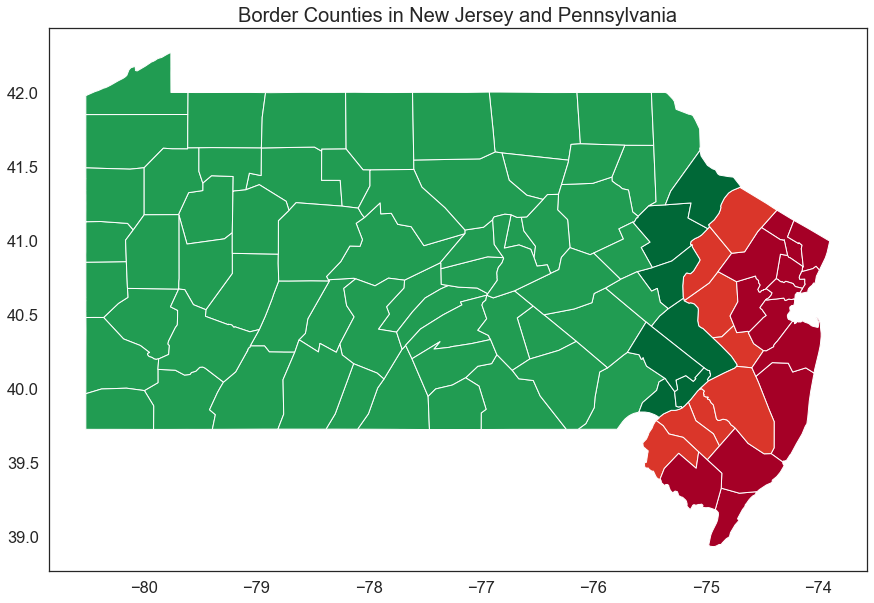

In [26]:
import geopandas as gpd

shp = gpd.read_file('data/wk10/geojson-counties-fips.json') # read in the counties shapefile

subset=shp[shp['STATE'].isin(['34','42'])] # new jersey = 34, pennsylvania = 42, new york = 36

subset['neighbors']= 0 # create a new column called neighbors

for index, row in subset.iterrows():  # iterate through each row in the counties shapefile
    buffered= row['geometry'].buffer(0.1) # create a buffer around the county so that it overlaps with its neighbors
    neighbors = list(set(subset[subset.geometry.overlaps(buffered)].STATE.tolist()).difference([row.STATE])) # check which counties overlap with the buffer, grab the state code, and remove the current county's state code
    subset.at[index, "neighbors"] = ", ".join(neighbors) # add the list of neighbors to the neighbors column

subset['border']=np.where(subset['neighbors']=='',0,1) # create a new column called border that is 1 if the county is on the border and 0 if it is not

subset['viscol']=subset['STATE'].astype(int)+subset['border'] # create a new column that combines the state code and the border column
subset.plot(column='viscol',legend=False, figsize=(20,10), cmap='RdYlGn') # plot the counties and color them by the border column
plt.title('Border Counties in New Jersey and Pennsylvania', fontsize=20) # add a title

The plot above shows counties in Pennsylvania in green, and New Jersey in red. Dark green counties are border counties in PA, while light red counties are border counties in NJ. Under the assumption that these counties are going to be very similar to each other in most ways other than the fact that NJ implemented a minimum wage law, the simplest regression discontinuity desgin would basically just be a regression of the following form: 

In [40]:
border_counties=subset[subset['border']==1]['id'].tolist() # create a list of the border counties
rdd=counties[(counties['year']>2007)&(counties['county_fips'].isin(border_counties))] # subset the counties data to only include border counties and years after 2007
rdd_model = ols('unemployment ~ state', rdd[rdd['year']>2014]).fit()

print(rdd)

ValueError: mismatch between column_names and columns coded by given terms

In [27]:
border_counties=subset[subset['border']==1]['id'].tolist() # create a list of the border counties
rdd=counties[(counties['year']>2007)&(counties['county_fips'].isin(border_counties))] # subset the counties data to only include border counties and years after 2007
rdd_model = ols('unemployment ~ C(state)', rdd[rdd['year']>2014]).fit()
print(rdd_model.summary())

ValueError: mismatch between column_names and columns coded by given terms

In [33]:
df=pd.read_csv('data/wk10/elections.csv')
df

,county_fips,year,d_votes,r_votes
0,1001,2000,28.719200,69.694328
1,1001,2004,23.694039,75.673522
2,1001,2008,25.773021,73.613637
3,1001,2012,26.587832,72.618252
4,1001,2016,23.769671,72.766588
...,...,...,...,...
18922,56045,2004,17.099057,80.748821
18923,56045,2008,19.273579,76.684241
18924,56045,2012,12.563263,83.983328
18925,56045,2016,8.479864,86.018151
